In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Audio
import librosa
import math

In [2]:
# Constants
sr  = 44100         # Sample rate
gps = 3             # Grids per sample
c0  = 340           # Speed of sound
h   = 0.004         # Spatial grid size
k   = 1 / gps / sr  # Temporal grid size
lam = c0 * k / h    # Courant's number
num_sgrid = 501

lam

0.6424792139077853

In [3]:
# Functions

def initial_waveform():
    return np.zeros(num_sgrid, dtype=np.float32)

def fdtd_matrix(boundary='neumann'):
    mat = torch.diag(torch.ones(num_sgrid) * 2 * (1 - lam**2)) + \
          torch.diag(torch.ones(num_sgrid - 1) * lam**2, diagonal=1) + \
          torch.diag(torch.ones(num_sgrid - 1) * lam**2, diagonal=-1)
    
    if boundary == 'neumann':
        mat[0][0] = mat[-1][-1] = 2 - lam**2
    elif boundary == 'dirichlet':
        mat[0][0] = mat[0][1] = mat[1][0] = mat[-1][-1] = mat[-1][-2] = mat[-2][-1] = 0
    else:
        raise ValueError("Unknown boundary condition")

    return mat

# Positive sine wave
def impulse_sin(t, freq):
    phase = 2 * np.pi * freq * t
    return (0 < np.sin(phase)) * np.sin(phase)

# Raised cosine impulse train
def impulse_rcos(t, freq, width):
    phase_n = (freq * t) % 1  # normalized phase (0~1)
    return (phase_n < width) * (1 - np.cos(2 * np.pi * (phase_n / width)))

def lip_pressure(t, freq):
    if t < 1:
        return impulse_rcos(t, freq, 0.3)
    return 0

In [4]:
# Simulate and generate animated plot

def sim_anim(nsteps, steps_per_frame, lip_freq, pre_steps=0):
    matB    = fdtd_matrix()

    time    = 0
    w_prev  = initial_waveform()
    w_now   = w_prev.copy()
    pl_prev = lip_pressure(0, lip_freq)
    pl_now  = lip_pressure(0, lip_freq)

    def step():
        nonlocal time, w_prev, w_now, pl_prev, pl_now
        
        time += k

        # Wave propagation
        w_next = matB @ w_now - w_prev  # Neumann boundary
        w_prev = w_now
        w_now = w_next

        # Lip coupling
        pl_prev = pl_now
        pl_now = lip_pressure(time, lip_freq)
        # The time-derivative of the wave function equals p / rho_0.
        # So to update the wave function at z=0, we just add (p / rho_0 * k) to the previous value.
        w_now[0] += (pl_now - pl_prev) * k


    def animate(t):
        line.set_ydata(w_now)
        for _ in range(steps_per_frame):
            step()
        return ax,


    for _ in range(pre_steps):
        step()

    # Generate an animated plot of the wave function.
    # We must close plt so that the plot generated by itself won't be displayed.
    # Instead, we only want the animation to appear, which is done by the last line.
    fig, ax = plt.subplots()
    ax.set_ylim((-0.005, 0.005))
    line, = ax.plot(w_now)
    plt.close()

    plt.rcParams["animation.html"] = "jshtml"
    return FuncAnimation(fig, animate, frames=int(nsteps / steps_per_frame))

sim_anim(10001, 50, 340 * 2)

In [5]:
# Generate simuated sound

def sim_sound(nsamples, lip_freq):
    matB    = fdtd_matrix()
    
    nsteps      = nsamples * gps
    pickup_pos  = num_sgrid - 1

    time    = 0
    w_prev  = initial_waveform()
    w_now   = initial_waveform()
    pl_prev = lip_pressure(0, lip_freq)
    pl_now  = lip_pressure(0, lip_freq)

    # loss = 2 / sr / gps

    def step():
        nonlocal time, w_prev, w_now, pl_prev, pl_now
        
        time += k

        # Wave propagation
        w_next = matB @ w_now - w_prev  # Neumann boundary
        w_prev = w_now
        w_now = w_next

        # Lip coupling
        pl_prev = pl_now
        pl_now = lip_pressure(time, lip_freq)
        # The time-derivative of the wave function equals p / rho_0.
        # So to update the wave function at z=0, we just add (p / rho_0 * k) to the previous value.
        w_now[0] += (pl_now - pl_prev) * k

        # Loss
        w_now[-1] *= (1 - 1000 * k)

    sound = np.zeros(nsamples)

    for i in range(nsamples):
        sound[i] = w_now[pickup_pos]
        for _ in range(gps):
            step()
    
    return sound

sound = sim_sound(3 * sr, 85 * 3)

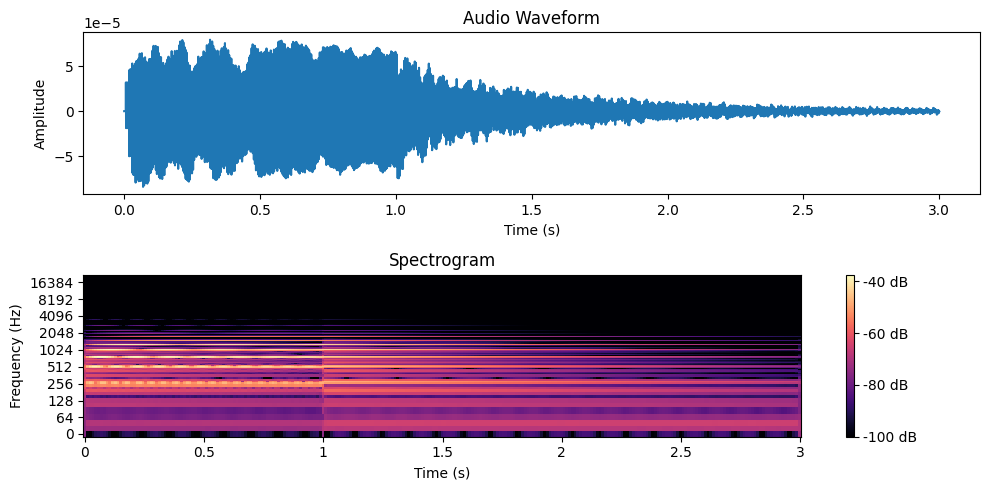

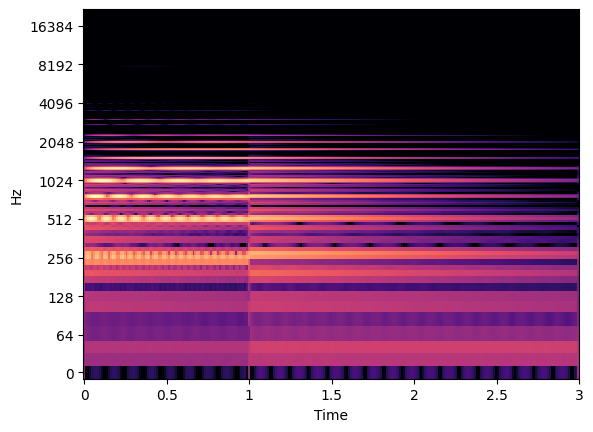

In [6]:
# Plots

# Audio output
display(Audio(sound, rate=sr))

# Plot audio waveform
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, len(sound) / sr, num=len(sound)), sound)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Compute and plot spectrogram
D = librosa.stft(sound)
D_db = librosa.amplitude_to_db(np.abs(D))

plt.subplot(2, 1, 2)
librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()
librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')

In [7]:
# Sine waves for comparison
sines = [np.sin(np.linspace(0, 2 * np.pi * 85 * i, sr)) for i in range(1, 10)]

for sine in sines:
    display(Audio(sine, rate=sr))